# Analyzing Hippocampal Spike Trains Tutorial 2018

This tutorial is using data that was gathered by Kamran Diba with Gyorgy Buzsaki and published in several groundbreaking papers including:

"Forward and reverse hippocampal place-cell sequences during ripples", _Nature Neuroscience_, 2007
"Hippocampal network dynamics constrain the time lag between pyramidal cells across modified environments", _J. Neuroscience_, 2008

The data for these papers was posted on the [CRCNS archive](https://f1000research.com/articles/3-98/v1) as well as part of [code](https://github.com/kemerelab/UncoveringTemporalStructureHippocampus) posted for ["Uncovering temporal structure in hippocampal output patterns", _eLife_, 2018](https://elifesciences.org/articles/34467).

Notebook was modified from the [nelpy](https://github.com/nelpy/example-analyses/blob/master/LinearTrackDemo.ipynb) by _Etienne Ackermann_ and modified by _Caleb Kemere_ for the 2018 Dartmouth MIND summer school.

## 1. Import useful packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import struct

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

# assume default aesthetics
npl.setup()

%matplotlib inline

/home/ckemere/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


## 2. Obtain example data

We will look for data inside your current working directory. The nelpy loading functions are just wrapping the pickling process. 

In [2]:
import os

load_from_nel = True

if load_from_nel:
    jar = nel.load_pkl('fig1.nel')
    exp_data = jar.exp_data
    aux_data = jar.aux_data
    del jar

In [163]:
session = '16-40-19'; segment = 'short' # 'long' or 'short'
#pos = nel.AnalogSignalArray(np.vstack((x1,y1)), timestamps=timestamps)
pos = aux_data[session][segment]['pos2d']

st = exp_data[session]['spikes_noIN'][pos.support]

PBEs = aux_data[session][segment]['PBEs_noIN'].support

## 3. Look at position data

In the experiment we're analyzing, the rat was running back and forth on a linear track, receiving reward on either end. During this process, its position was tracked using head-mounted LEDs. In the pickle that we've loaded, we have two types of data - the times of action potentials from a large number of isolated neurons and a record of the rats position during the neural recordings.

These sorts of experiments are typically constructed as a series of epochs in which the animal is allowed to run on a track, separated by periods when they are put into small container where they can rest. The clock is typically allowed to run throughout this entire period, and experimental metadata records the boundaries of these epochs. For the sake of this tutorial, we've extracted a single epoch.

In [8]:
print(pos) #inspect the pos object


<AnalogSignalArray at 0x7f29dcc41f98: 2 signals> for a total of 22:10 minutes


### 3.b) Create 2D trajectory object

We can plot the position/trajectory object like so:

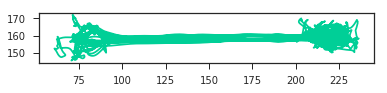

In [10]:
#npl.plot2d(pos) # plot the entire trajectory
plt.plot(pos.ydata[0,:],pos.ydata[1,:])
ax = plt.gca()
ax.set_aspect('equal')

We can see the boundaries of this linear track epoch by simply inspecting pos, like below):

In [11]:
pos.support.time # print the time boundaries on which pos is defined

array([[1250, 2580]])

and so we can easily plot the trajectory, say, for the first 30 seconds while the animal was on the track. One way to do this, is to define an epoch, and then to restrict the position object to that newly defined epoch. Let's do this now:

In [12]:
ep = nel.EpochArray([1300, 1320])
ep

<EpochArray at 0x7f29d74e8b70: 1 epoch> of duration 20 seconds

/mnt/d/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:632: UserWarning: ignoring signal outside of support


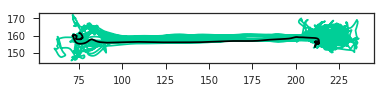

In [13]:
npl.plot2d(pos) # plot the entire trajectory
npl.plot2d(pos[ep], color='k') # plot pos restricted to ep
ax = plt.gca()
ax.set_aspect('equal')

This way of filtering / restricting the data is very powerful, and we will use it later on to get spikes only during times when the animal was running faster than some threshold, and so on.

Before we move onto the next phase (linearization), let's take a quick aside to make the plot above a bit nicer. First, we may want to set the aspect ratio to equal, and we may also want to add titles, labels, etc. We may even want to smooth the trajectory.

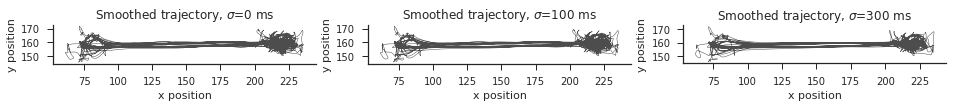

In [14]:
sigmas = [0, 0.1, 0.3] # smooth trajectory in time, with sigma = 100 ms (=0.1 seconds)

fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for sigma, ax in zip(sigmas, axes):
    npl.plot2d(pos.smooth(sigma=sigma), lw=0.5, color='0.3', ax=ax)
    ax.set_aspect('equal')  
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    npl.utils.clear_right(ax)
    npl.utils.clear_top(ax)
    ax.set_title('Smoothed trajectory, $\sigma$={} ms'.format(round(sigma*1000)))

### 3.c) Linearize position

We can do the rest of our analysis in 2D, but sometimes it's nicer to linearize the position data first. Here, we simply use PCA (a dimensionality reduction technique) to find the direction of maximal variance in our position data, and we use this as our new 1D linear track axis.

**NOTE**: To use PCA from scikit-learn, we need to provide our data as an n_samples x n_features matrix. The internal representation of the `nelpy` `AnalogSignalArray` can actually be changed, but we can always explicitly ask to get the underlying data back in a particular format. We do this, by asking for `_ydata_colsig`, which means that we want each feature (or signal, or component) to be a column of the data matrix. Here you shouldn't be concerned with the favt that we asked for `_ydata`: this is simply an internal naming convention of the `AnalogSignalArray`, and has nothing to do with our `x` and `y` coordinates. More precisely, `_ydata` refers to the _entire_ data matrix, in contrast to `_tdata` which stores the timestamp info. So `_ydata` contains both `x1` and `y1`.

In [15]:
from sklearn.decomposition import PCA
X = pos._ydata_colsig   # we access the 
pca = PCA(n_components=1)
Xlinear = pca.fit_transform(X)

Text(0.5,1,'linearization using PCA')

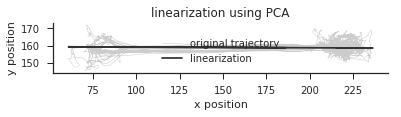

In [16]:
Xlinear_ = pca.inverse_transform(Xlinear)
ax = npl.plot2d(pos, lw=0.5, color='0.8', label='original trajectory')
plt.plot(Xlinear_[:,0], Xlinear_[:,1], color='0.2', label='linearization')
plt.legend()
ax.set_aspect('equal')  
ax.set_xlabel('x position')
ax.set_ylabel('y position')
npl.utils.clear_right(ax)
npl.utils.clear_top(ax)
ax.set_title('linearization using PCA')

We also re-scale our data to range from 0 to 100 (so that we can express movement along the track as a percentage). Typically we would actually scale our data to some physical dimension or unit, such as cm, and not pixels as we have it above, or percentage, as we're transforming it into here.

In [17]:
Xlinear = Xlinear - np.min(Xlinear)
Xlinear = (Xlinear / np.max(Xlinear))*100

We now have `Xlinear` as a scaled (0 to 100) position variable, as a numpy array. We want to put it back into a `nelpy` `AnalogSignalArray` container, so that we can slice and interogate it as before:

In [18]:
pos1d = nel.AnalogSignalArray(Xlinear, timestamps=pos.time, support=pos.support, fs=60)
print('pos:  ', pos)
print('pos1d:', pos1d)

pos:   <AnalogSignalArray at 0x7f29dcc41f98: 2 signals> for a total of 22:10 minutes
pos1d: <AnalogSignalArray at 0x7f29d6cf5a90: 1 signals> for a total of 22:10 minutes


We see that `pos1d` now only has 1 signal, as expected, and if we plot it, we can confirm that it ranges between 0 and 100:

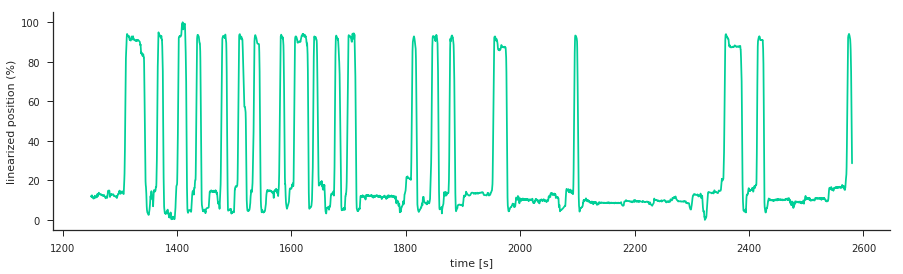

In [19]:
fig = plt.figure(figsize=(15,4))
npl.plot(pos1d)
ax = plt.gca()
ax.set_xlabel('time [s]')
ax.set_ylabel('linearized position (%)')
npl.utils.clear_right(ax)
npl.utils.clear_top(ax)

## 4. Extract spike times

After we spike sort, we end up with the times for every action potential from every neuron. Spike times are given in seconds, so floating point numbers are used. We store this in a structure called a SpikeTrainArray.

In [20]:
print(st)

<SpikeTrainArray at 0x7f2a1802b908: 103 units> at 32552 Hz from 2006-6-07_16-40-19


Printing out our `SpikeTrainArray` (`st`) tells us that we have 103 units, sampled at 32,552 Hz (this is an estimate from the data). 

We can ask several things from this `SpikeTrainArray` object, such as the number of spikes for each unit. To do that, we simply access the `.n_spikes` property, which returns the number of spikes associated with each unit as an array:

In [21]:
st.n_spikes

array([  431,   299,   187,  1370,   104,  3458,   357,  2788,  2134,
        1584,  1031,   738,   130,    81,    93,   484,  1662,   542,
        1724,   225,  1266,    49,  3307,   116,   726,    31,   312,
           2,  1024,   341,   989,    73,   172,   116,   384,  3165,
        1451,   660,    79,  2653,   130,    73,   277,  1319,    31,
        9275,  3043,   682,  1028,  2549, 13829,  3033,   314, 10020,
        3499,  2591,    82,  1245,   346,  1764,  1012,  2655,    44,
        1580,    57,   758,   125,   335,    51,   197,   651,  2004,
         120,     3,  1481,   105,   379,    81,  1467,   275,    53,
         764,  1434,  1972,     1,   604,    58,   494,    19,  4929,
         339,  1866,   832,   126,  5350,   985,  1337,   262,   450,
         766,   974,   570,  5574])

Like all other core `nelpy` objects, a `SpikeTrainArray` has a _support_ on which it is defined, and so we can always get timing information by accessing the underlying support object (instead of using `start` and `stop` explicitly, as we did above).

Let's calculate the average firing rates using `nelpy`:

In [22]:
avg_firing_rates = st.n_spikes / st.support.duration

print(avg_firing_rates)

[3.24060150e-01 2.24812030e-01 1.40601504e-01 1.03007519e+00
 7.81954887e-02 2.60000000e+00 2.68421053e-01 2.09624060e+00
 1.60451128e+00 1.19097744e+00 7.75187970e-01 5.54887218e-01
 9.77443609e-02 6.09022556e-02 6.99248120e-02 3.63909774e-01
 1.24962406e+00 4.07518797e-01 1.29624060e+00 1.69172932e-01
 9.51879699e-01 3.68421053e-02 2.48646617e+00 8.72180451e-02
 5.45864662e-01 2.33082707e-02 2.34586466e-01 1.50375940e-03
 7.69924812e-01 2.56390977e-01 7.43609023e-01 5.48872180e-02
 1.29323308e-01 8.72180451e-02 2.88721805e-01 2.37969925e+00
 1.09097744e+00 4.96240602e-01 5.93984962e-02 1.99473684e+00
 9.77443609e-02 5.48872180e-02 2.08270677e-01 9.91729323e-01
 2.33082707e-02 6.97368421e+00 2.28796992e+00 5.12781955e-01
 7.72932331e-01 1.91654135e+00 1.03977444e+01 2.28045113e+00
 2.36090226e-01 7.53383459e+00 2.63082707e+00 1.94812030e+00
 6.16541353e-02 9.36090226e-01 2.60150376e-01 1.32631579e+00
 7.60902256e-01 1.99624060e+00 3.30827068e-02 1.18796992e+00
 4.28571429e-02 5.699248

Now wasn't that a little simpler? But the real beauty comes in when the `SpikeTrainArray` is not simply defined on one continuous epoch, but on many smaller epochs. For example, we might be interested in asking _"what is the average firing rate for each unit, during periods when the animal was running?"_---in that case, the firing rate calculation using the list of lists approach would become exceedingly painful, but we would be able to simply write
```
avg_firing_rates_during_run = st[run_epochs].n_spikes / st[run_epochs].support.duration 
```
which will work just the same, even though `st[run].support` now consists of many discontiguous epochs.

### Visualize spikes with raster plots

Nelpy has several built-in plot types (we have already seen `npl.plot2d()` before), and one that is frequently useful is the `rasterplot()`.

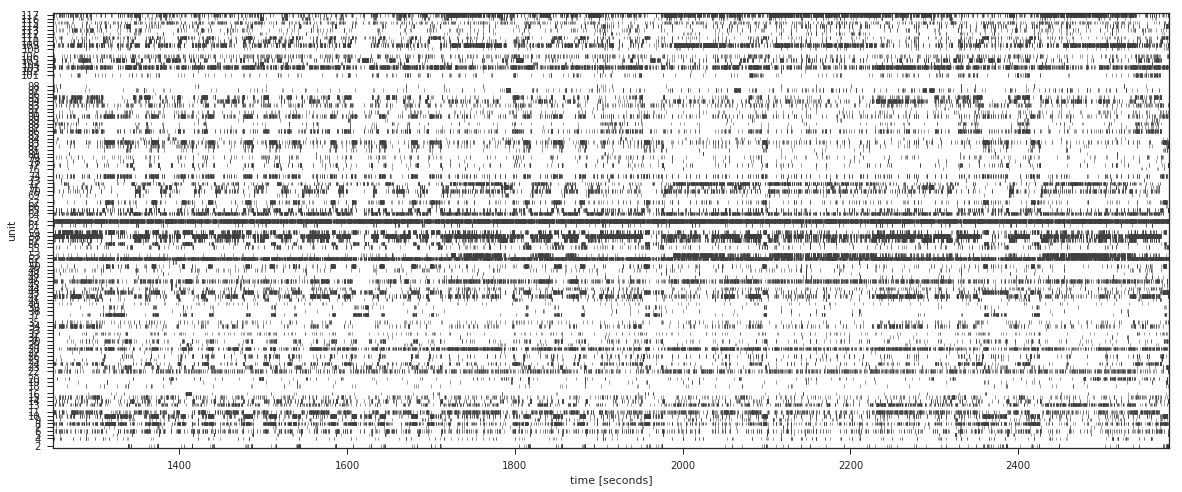

In [23]:
fig, ax = plt.subplots(ncols=1, figsize=(20,8))

# use nelpy to plot the spike raster
npl.rasterplot(st, lw=0.5, ax=ax)
ax.set_xlabel('time [seconds]')
ax.set_ylabel('unit')
ax.set_xlim(st.support.start,st.support.stop);

If we look a bit more closely, it looks like we might could make out the periods when the rat was running. 

We can define "running" as times when the rat's speed was elevated. Commonly chosen speeds are in the range of 3 to 10 cm/s.  We smooth our speed estimates with a Guassian kernel with sigma = 100 ms, and then we return those epochs where the animal was running at least 5 percent per second.

**Note**: Usually we would measure the speed in cm/s or similar, but recall that our position has been scaled to be a percentage; the track was about 150 cm long, so that percent/s is not too different from cm/s.

In [24]:
sigma_100ms = 0.1

# compute and smooth speed of linearized position
speed1 = nel.utils.dxdt_AnalogSignalArray(pos1d, smooth=True, sigma=sigma_100ms)

# find epochs where the animal ran at least as fast as v1=5 percent per second
run_epochs = nel.utils.get_run_epochs(speed1, v1=5, v2=5)

The `get_run_epochs()` function has two thresholds (both set to 5 above). More specifically, the first threshold (`v1`) is referred to as the primary threshold, and this must be reached or exceeded for an epoch to be considered a candidate. But then the secondary threshold (`v2`) is used to determine the epoch boundaries.

For example, if we had used `v1=5, v2=3` then only epochs during which the animal reached a speed of at least 8 u/s would be considered, and the epoch boundaries would be when the animal ran ran at or slower than 3 u/s, starting at the peak speed of >8 u/s.

There are other possible arguments, too, so that we can e.g. ask that the animal must run at least 5 u/s for some minimum period of time, and so on.

Let's see for how much time the animal actually ran faster than 5 percent per second:

In [25]:
print(run_epochs)

<EpochArray at 0x7f29bc5e9470: 101 epochs> of duration 2:45:716 minutes


We see that there are 101! short epochs during the animal ran sufficiently fast, and that the total amount of time spent running at this speed or faster, is about 4 minutes and 18 seconds (out of approximately 16 minutes spent on the track).

As promised before, we can now easily (trivially) calculate the firing rates of all the units, only during times when the animal was running:

In [26]:
avg_firing_rates_during_run = st[run_epochs].n_spikes / st[run_epochs].support.duration 

for unit, (run_rate, avg_rate) in enumerate(zip(avg_firing_rates_during_run, avg_firing_rates)):
    print('unit {}: {:2.3f} Hz (run and rest: {:2.3f} Hz)'.format(unit+1, run_rate, avg_rate))

unit 1: 1.134 Hz (run and rest: 0.324 Hz)
unit 2: 0.151 Hz (run and rest: 0.225 Hz)
unit 3: 0.688 Hz (run and rest: 0.141 Hz)
unit 4: 2.160 Hz (run and rest: 1.030 Hz)
unit 5: 0.115 Hz (run and rest: 0.078 Hz)
unit 6: 3.922 Hz (run and rest: 2.600 Hz)
unit 7: 0.247 Hz (run and rest: 0.268 Hz)
unit 8: 4.230 Hz (run and rest: 2.096 Hz)
unit 9: 1.472 Hz (run and rest: 1.605 Hz)
unit 10: 0.646 Hz (run and rest: 1.191 Hz)
unit 11: 3.355 Hz (run and rest: 0.775 Hz)
unit 12: 0.290 Hz (run and rest: 0.555 Hz)
unit 13: 0.042 Hz (run and rest: 0.098 Hz)
unit 14: 0.157 Hz (run and rest: 0.061 Hz)
unit 15: 0.030 Hz (run and rest: 0.070 Hz)
unit 16: 0.211 Hz (run and rest: 0.364 Hz)
unit 17: 1.243 Hz (run and rest: 1.250 Hz)
unit 18: 1.141 Hz (run and rest: 0.408 Hz)
unit 19: 2.951 Hz (run and rest: 1.296 Hz)
unit 20: 0.718 Hz (run and rest: 0.169 Hz)
unit 21: 4.737 Hz (run and rest: 0.952 Hz)
unit 22: 0.060 Hz (run and rest: 0.037 Hz)
unit 23: 1.478 Hz (run and rest: 2.486 Hz)
unit 24: 0.229 Hz (r

We can also plot the linearized trajectory only during those run epochs. Each new color indicates that it is a new epoch. The black on the bottom figure corresponds to epochs when the animal did not meet the 8 percent per second requirement, and so those are when the animal is considered to be at rest.

/mnt/d/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:632: UserWarning: ignoring signal outside of support
/mnt/d/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:632: UserWarning: ignoring signal outside of support


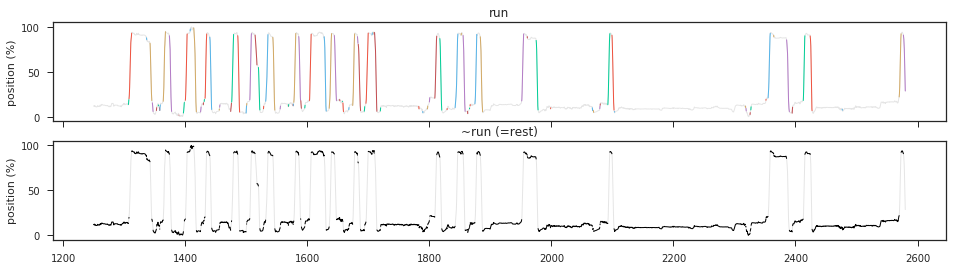

In [27]:
with npl.FigureManager(show=True, nrows=2, figsize=(16,4)) as (fig, axes):
    npl.utils.skip_if_no_output(fig)
    ax0, ax1 = axes
    for ax in axes:
        ax.plot(pos1d.time, pos1d.asarray().yvals, lw=1, alpha=0.2, color='gray')
        ax.set_ylabel('position (%)')
    
    npl.plot(pos1d[run_epochs], ax=ax0, lw=1, label='run')
    npl.plot(pos1d[~run_epochs], ax=ax1, lw=1, label='run', color='k')
    
    npl.utils.no_xticklabels(ax0)
    
    ax0.set_title('run')
    ax1.set_title('~run (=rest)')

Finally, we can highlight the spike trains that happened during running.

/home/ckemere/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
/home/ckemere/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 


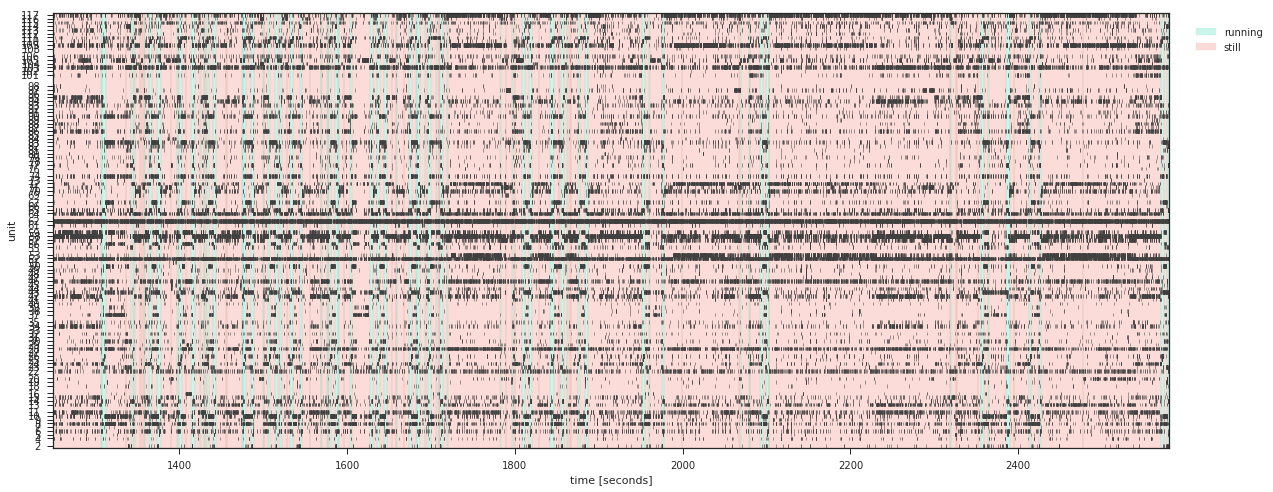

In [28]:
fig, ax = plt.subplots(ncols=1, figsize=(20,8))

# use nelpy to plot the spike rasters
npl.rasterplot(st, lw=0.5, ax=ax)

npl.epochplot(run_epochs, alpha=0.2, hatch='', color=npl.colors.sweet.green, label='running')
npl.epochplot(pos.support-run_epochs, alpha=0.2, hatch='', color=npl.colors.sweet.red, label='still')

ax.set_xlabel('time [seconds]')
ax.set_ylabel('unit')
ax.set_xlim(st.support.start,st.support.stop);
#ax.set_xlim(1400,1600);

plt.legend(loc=(1.02,0.9))

## 5. Estimate tuning curves

To avoid contamination with ripple and other non-place activity, place fields are (historically) estimated during periods when animals are running. Now that we have the epochs during which the animal was running, we can use it to restrict our `SpikeTrainArray` to those epochs. Then we will use these spikes, along with the position data, to estimate the spatial tuning curves.

In [33]:
st_run = st[run_epochs] # restrict spike trains to those epochs during which the animal was running

We *bin* our spikes into 50 ms bins, so that we can count the number of spikes in a small window of time, which we will then later associate with the particular position bin that the animal was at when those spikes occured. Note that there are other ways of doing firing rate estimation just at spike times, but binning just makes life easier!


In [34]:
ds_run = 0.125 # 125 ms

bst_run = st_run.bin(ds=ds_run)

#  Could also smooth and re-bin:
# ds_10ms = 0.01
# sigma = 0.250 # 250 ms spike smoothing
# bst_run = st_run.bin(ds=ds_10ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_10ms)


/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1588: UserWarning: epoch duration is less than bin size: ignoring...
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1588: UserWarning: epoch duration is less than bin size: ignoring...
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1588: UserWarning: epoch duration is less than bin size: ignoring...


To estimte a place field, we normalize binned firing by occupancy. 
Below is an example for one neuron. There's a nice convenience function, though!

### Example place field estimation

/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1588: UserWarning: epoch duration is less than bin size: ignoring...
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1588: UserWarning: epoch duration is less than bin size: ignoring...
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1588: UserWarning: epoch duration is less than bin size: ignoring...


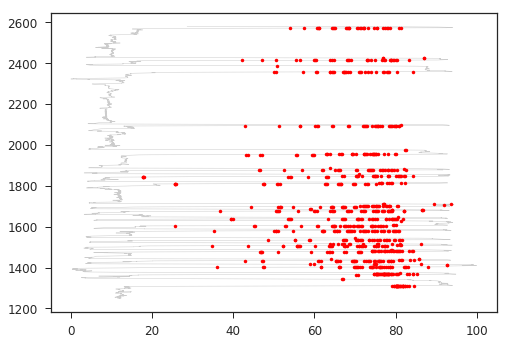

In [136]:
plt.plot(pos1d.ydata.T, pos1d.time, lw=0.5, c='0.8')
unit_id = 26
spike_times = st_run[:,unit_id].time
_, pos_at_spikes = pos1d.asarray(at=spike_times)
plt.plot(pos_at_spikes, spike_times.T, '.', c='red')
#ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.')
#ax.set_aspect('equal')

bst_single = st_run[:,unit_id].bin(ds=ds_run)


Bin spikes and occupancy into 50 bins.

In [146]:
# Calculate spatial occupancy
xmax = 100
xmin = 0
nbins = 50
bins = np.linspace(xmin,xmax, nbins)
pos_at_times = pos1d.asarray(at=bst_single.bin_centers)
occupancy, _ = np.histogram(pos_at_times, bins=bins, range=(xmin, xmax))



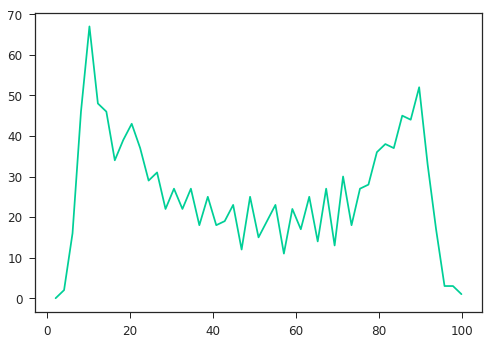

In [147]:
xbins = (bins + xmax/nbins)[:-1]
plt.plot(xbins,occupancy)

In [156]:
ratemap = np.zeros((nbins))
ext_bin_idx = np.digitize(pos_at_times.yvals, bins, right=True)

for tt, bidx in enumerate(ext_bin_idx):
    ratemap[bidx-1] += bst_single.data[0,tt]


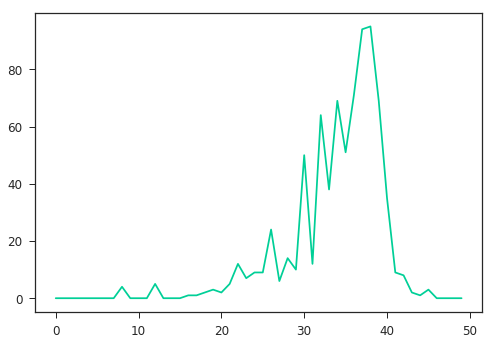

In [159]:
plt.plot(ratemap)

/home/ckemere/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide


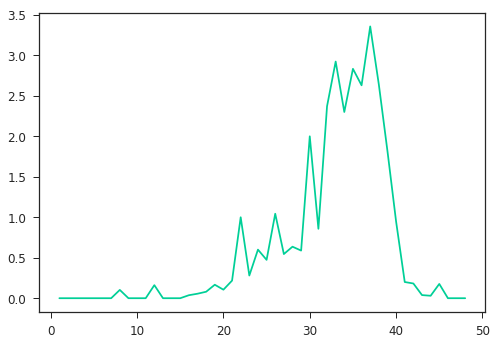

In [162]:
plt.plot(ratemap[:-1]/occupancy)

We now estimate the tuning curves using the binned spikes during run (`bst_run`), and we partition our linear track into `n_extern=50` equal-sized spatial bins, and we specify that the linearized position ranges from `extmin=0` to `extmax=100`. We also smooth the estimated tuning curves with a 0.2 cm smoothing kernel (this should be imperceptable, and a larger value for sigma should really be used, but we can always apply the smoothing later, so it's not a real problem).

In [42]:
sigma = 0.2 # smoothing std dev in cm
tc = nel.TuningCurve1D(bst=bst_run, extern=pos1d, n_extern=50, extmin=0, extmax=100, sigma=sigma, min_duration=1)

/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:344: UserWarning: unit tags have not yet been specified


Finally, we reorder the units by their peak firing positions on the track, simply to make visualization a little nicer:

In [43]:
tc = tc.reorder_units()

That's it! Let's see what we've got:

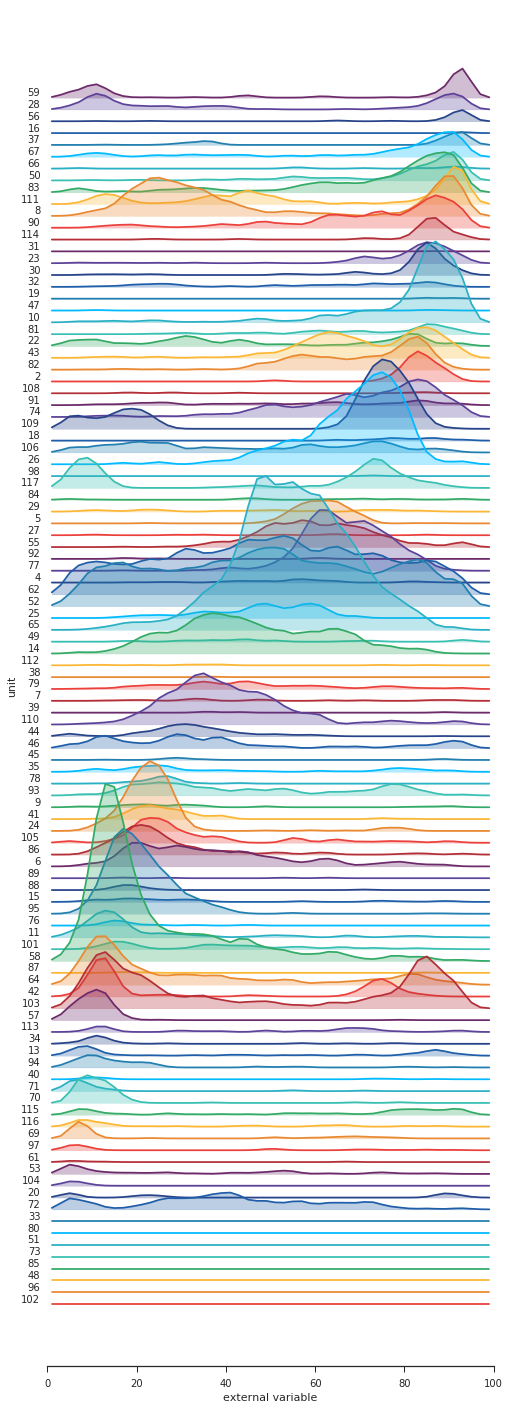

In [37]:
npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(8,25)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.plot_tuning_curves1D(tc.smooth(sigma=2), normalize=False, pad=3)

We see that some units have spatially localized tuning curves, and some don't. Also, some units have large firing rates, and some don't. To see the shape of all the tuning curves better, we can normalize the peak firing rates like so:

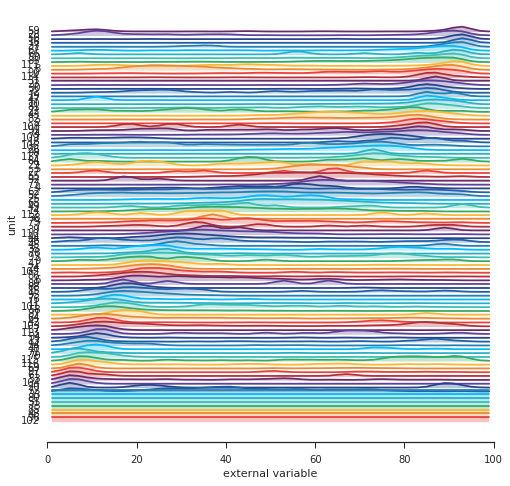

In [38]:
npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(8,8)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.plot_tuning_curves1D(tc.smooth(sigma=2), normalize=True, pad=0.8)

This normalized view allows us to see the shapes of the tuning curves more clearly, and we can see that some units are essentially flat, meaning they have NO spatial localization for their firing rates. This is partly due to there just being almost no spikes during run for those units though.

At any rate, let's filter out the units a little further, to try and figure out which ones might actually be place cells.

### Restrict subset of cells (units) to use for subsequent decoding and/or analysis

Here we may request to use
1. unimodal cells only,
1. pyramidal cells only,
1. active cells only,
1. any combination of the above, and other criteria

Here we only impose a minimum peak firing rate of 1.5 Hz, and we reject putative interneurons by imposing a maximum average firing rate of 5 Hz averaged over the entire track.

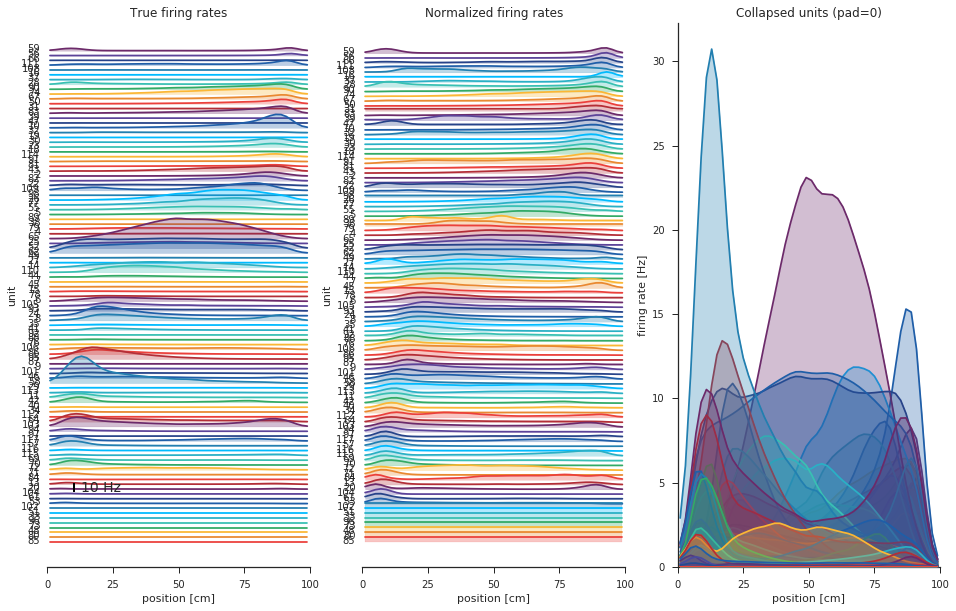

In [60]:
# set criteria for units used in decoding
min_peakfiringrate = 1.5 # Hz
max_avgfiringrate = 15 # Hz
peak_to_mean_ratio_threshold = 1 # peak firing rate should be greater than 2.5 times mean firing rate

# unimodal_cells = find_unimodal_tuningcurves1D(smoothed_rate, peakthresh=0.5)

# enforce minimum peak firing rate
unit_ids_to_keep = set(np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.max(axis=1)>min_peakfiringrate).squeeze().tolist()])
# enforce maximum average firing rate
unit_ids_to_keep = unit_ids_to_keep.intersection(set( np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.mean(axis=1)<max_avgfiringrate).squeeze().tolist()]   ))

# enforce peak to mean firing ratio
peak_firing_rates = tc.max(axis=1)
mean_firing_rates = tc.mean(axis=1)
ratio = peak_firing_rates/mean_firing_rates
unit_ids_to_keep = unit_ids_to_keep.intersection(set(np.asanyarray(tc.unit_ids)[np.argwhere(ratio>=peak_to_mean_ratio_threshold).squeeze().tolist()]))

# reorder cells by peak firing location on track (this is nice for visualization, but doesn't affect decoding)
tc.reorder_units(inplace=True)

# with plt.xkcd():
with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, nrows=1, ncols=3, figsize=(16,10)) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        ax0, ax1, ax2 = axes

        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax0, pad=5.5);
        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax1, normalize=True, pad=0.9);
        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax2, pad=0);

        for ax in axes:
            ax.set_xlabel('position [cm]')
        npl.utils.xticks_interval(25, *axes)
        npl.utils.yticks_interval(5, ax2)
        npl.add_simple_scalebar("10 Hz", ax=ax0, xy=(10, 57), length=10, orientation='v', rotation_text='h', size=14)
#         npl.add_simple_scalebar("5 Hz", ax=ax1, xy=(10, 17.5), length=5, orientation='v', rotation_text='h', size=14)
        ax0.set_title('True firing rates', size=12)
        ax1.set_title('Normalized firing rates', size=12)
        ax2.set_title('Collapsed units (pad=0)', size=12)

## 6. Evaluate decoding performance

Next, having defined a subset of 50 place cells, we may reasonably want to ask how well these cells can represent the animal's location? We can evaluate the expected decoding performance by using a Bayesian decoder, and by evaluating the decoding accuracy on a test set.

Here, we use 5-fold cross-validation and the tuning curves of our 50 place cells to evaluate the performance, and the results are summarized in the figure below: 

/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:344: UserWarning: unit tags have not yet been specified
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:344: UserWarning: unit tags have not yet been specified
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

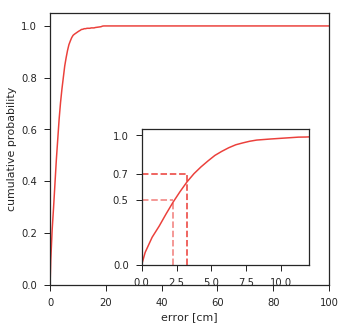

In [40]:
with npl.FigureManager(show=True, figsize=(5,5)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    
    ds_run = 0.125 # 125 ms
    ds_1ms = 0.01
#     st_run = st[run_epochs]

    # smooth and re-bin:
    bst_run = st_run.bin(ds=ds_1ms).smooth(sigma=0.5, inplace=True).rebin(w=ds_run/ds_1ms)
    
    bst = bst_run

    cumhist, bincenters = nel.decoding.cumulative_dist_decoding_error_using_xval(bst, extern=pos1d, extmax=100)
    npl.plot_cum_error_dist(bst=bst, extern=pos1d, extmin=0, extmax=100);


This tells us that, with probability 0.9, we can decode the animal's position to within about 10 percent of the true position. Recall that in our particular example, this means about 15 cm. The inset shows a zoomed-in view, from where we can see that with probability 0.7, we have an error of about 3 percent or 5 cm.

It's not the best decoding accuracy imaginable, but overall, not bad!

## Some additional views

In [64]:
# finally, convert remaining units into a list of indices
place_cell_unit_ids = list(unit_ids_to_keep)
non_place_cells = list(set(st.unit_ids) - set(place_cell_unit_ids))

# modify spike trains and ratemap to only include those units that passed all the criteria
tc_placecells = tc._unit_subset(place_cell_unit_ids)

place_cell_order = tc_placecells.get_peak_firing_order_ids()

new_unit_order = np.hstack((np.array(non_place_cells), np.array(place_cell_order)))
st.reorder_units_by_ids(new_unit_order, inplace=True)

sta_placecells = st._unit_subset(place_cell_unit_ids)


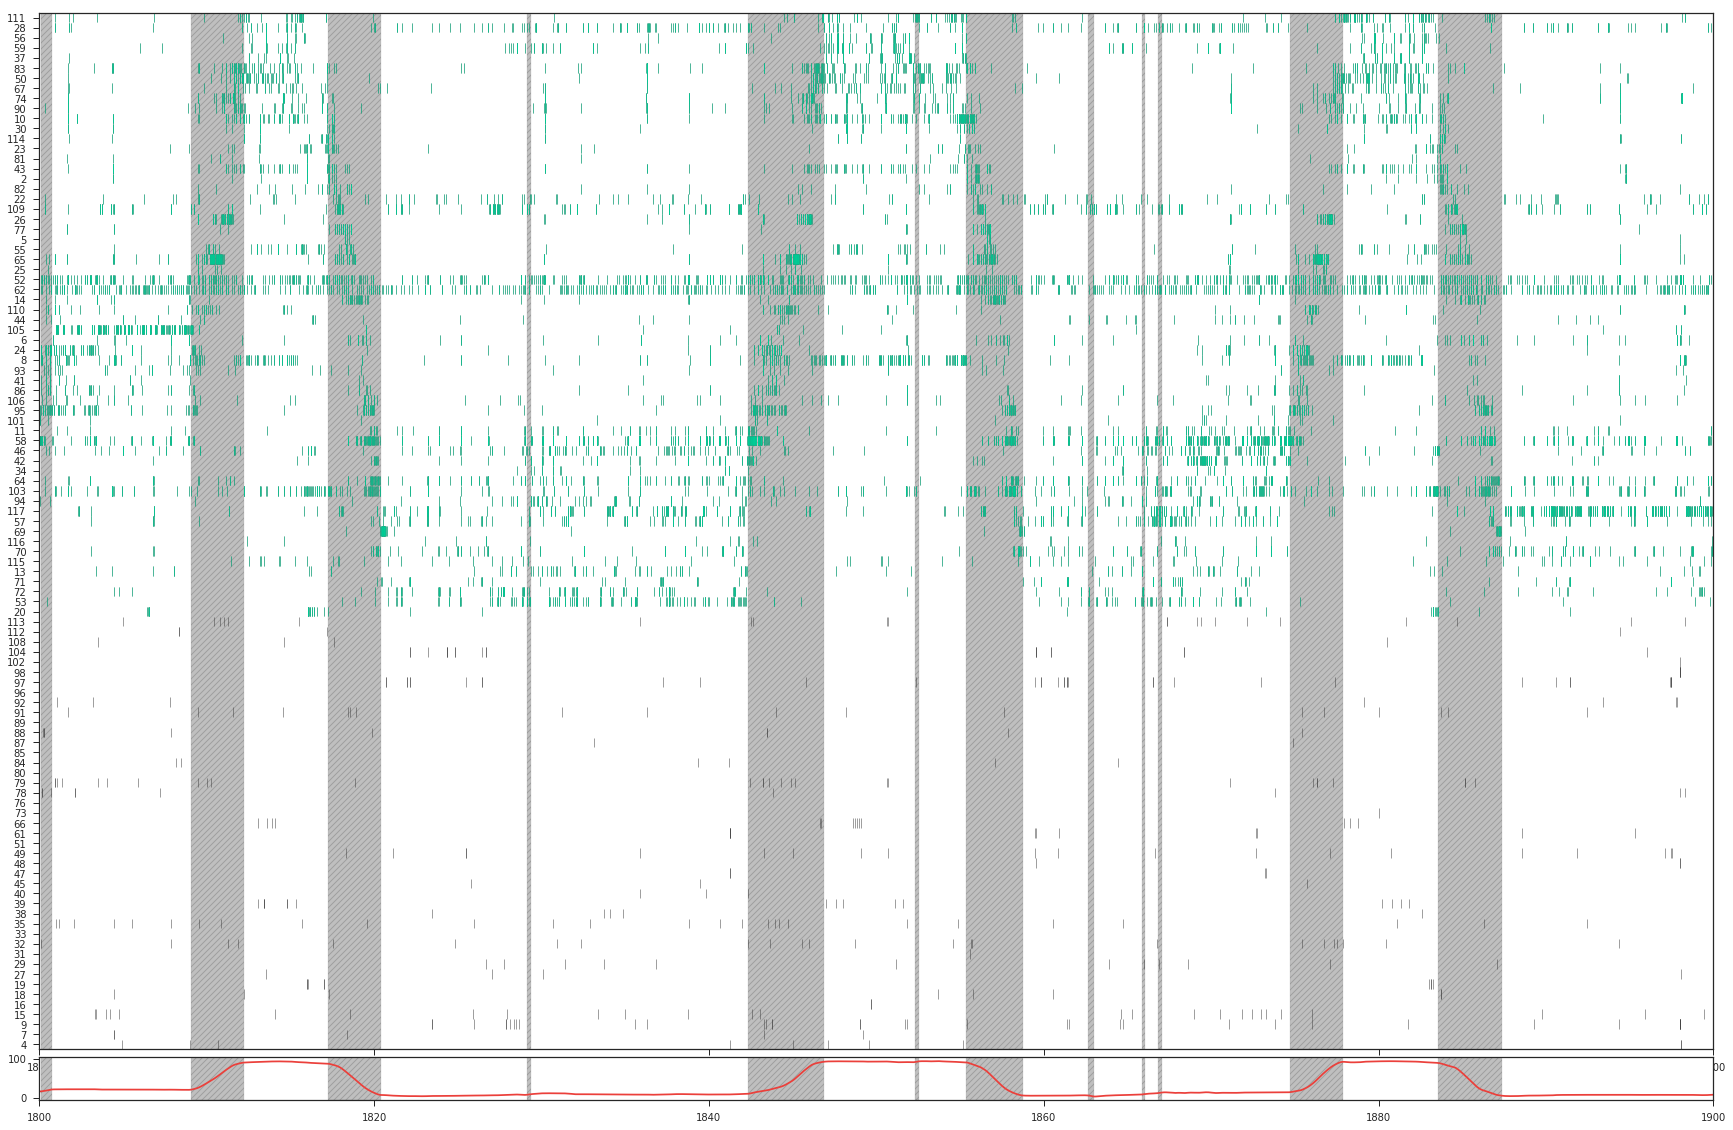

In [65]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

with npl.FigureManager(show=True, figsize=(30,20)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    
    
    npl.rasterplot(st, lw=0.5, ax=ax, vertstack=True)
    npl.rasterplot(sta_placecells, lw=0.5, color=npl.colors.sweet.green, vertstack=True)
    npl.epochplot(run_epochs)

    divider = make_axes_locatable(ax)

    axSpeed1d = divider.append_axes("bottom", size=0.6, pad=0.1)
    npl.plot(pos1d, ax=axSpeed1d)
    npl.epochplot(run_epochs, ax=axSpeed1d)

    xlims = (1800, 1900)

    ax.set_xlim(xlims)
    axSpeed1d.set_xlim(xlims)



Next, we take a look at where on the track spikes from a particular unit occurred:

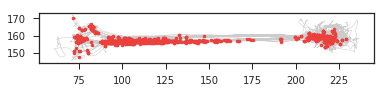

In [66]:
ax = npl.plot2d(pos, lw=0.5, c='0.8')
unit_id = 26
_, pos_at_spikes = pos.asarray(at=st[:,unit_id].time)
ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.')
ax.set_aspect('equal')

Text(0.5,1,'Spikes while at rest, unit 26')

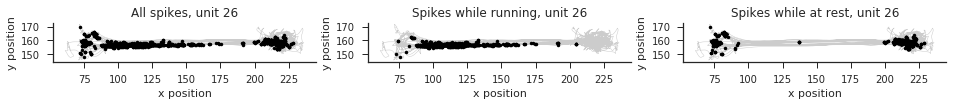

In [67]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

ax0, ax1, ax2 = axes

# plot trajectory in gray
for ax in axes:
    npl.plot2d(pos, lw=0.5, c='0.8', ax=ax)
    ax.set_aspect('equal')  
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    npl.utils.clear_right(ax)
    npl.utils.clear_top(ax)

unit_id = 26

# all spikes
at = st.loc[:,unit_id][pos.support].time
_, pos_at_spikes = pos.asarray(at=at)
ax0.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.', color='k')
ax0.set_aspect('equal')
ax0.set_title('All spikes, unit {}'.format(unit_id))

# spikes during RUN
at = st.loc[:,unit_id][run_epochs].time
_, pos_at_spikes = pos.asarray(at=at)
ax1.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.', color='k')
ax1.set_aspect('equal')
ax1.set_title('Spikes while running, unit {}'.format(unit_id))

# spikes during REST
at = st.loc[:,unit_id][~run_epochs].time
_, pos_at_spikes = pos.asarray(at=at)
ax2.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.', color='k')
ax2.set_aspect('equal')
ax2.set_title('Spikes while at rest, unit {}'.format(unit_id))

## 7. Replay analysis

Replay analysis begins with the tuning curves we've just defined. The next step, however, is to isolate the times when we expect to look for replay. These are usually defined in one of two ways - either by sharp wave ripples in the LFP or by bursts of population activity. For this tutorial, to avoid having to talk about LFP analysis (and to avoid big files), we'll use the latter.

In [93]:
def plot_all_PBEs(bst, spiketrainarray, tuningcurve, tc_placecells, idx=None, title_str=None):
    if idx is not None:
        bst = bst[idx]
    st = spiketrainarray
    tc = tuningcurve
    tc_placecells = tc_placecells

    no = tc_placecells.get_peak_firing_order_ids()
    st.reorder_units_by_ids(no, inplace=True)

    st_cut = st[bst.support]
    st_cut._support = bst.support # hacky fix so that we can plot events out of order
    st_cut = nel.utils.collapse_time(st_cut)

    # decode neural activity
    posterior, bdries, mode_pth, mean_pth = nel.decoding.decode1D(bst=bst, ratemap=tc, xmax=100)

    with npl.FigureManager(show=True, figsize=(0.2*bst.n_bins,4)) as (fig, ax):
        npl.utils.skip_if_no_output(fig)

        pixel_width = 0.5

        npl.imagesc(x=np.arange(bst.n_bins), y=np.arange(101), data=posterior, cmap=plt.cm.Spectral_r, ax=ax)
#         npl.utils.yticks_interval(310)
        npl.utils.no_yticks(ax)
        # plt.imshow(posterior, cmap=plt.cm.Spectral_r, interpolation='none', aspect='auto')
        ax.vlines(np.arange(bst.lengths.sum())-pixel_width, *ax.get_ylim(), lw=1, linestyle=':', color='0.8')
        ax.vlines(np.cumsum(bst.lengths)-pixel_width, *ax.get_ylim(), lw=1)

        ax.set_xlim(-pixel_width, bst.lengths.sum()-pixel_width)

        event_centers = np.insert(np.cumsum(bst.lengths),0,0)
        event_centers = event_centers[:-1] + bst.lengths/2 - 0.5

        ax.set_xticks(event_centers);
        if idx is not None:
            ax.set_xticklabels(idx);
        else:
            ax.set_xticklabels(np.arange(bst.n_epochs));

        npl.utils.no_xticks(ax)
        ax.set_ylim(0,100)

        divider = make_axes_locatable(ax)
        axRaster = divider.append_axes("top", size=1, pad=0)

        npl.rasterplot(st_cut, vertstack=True, ax=axRaster, lh=1.25)
        axRaster.set_xlim(st_cut.support.time.squeeze())
        bin_edges = np.linspace(st_cut.support.time[0,0],st_cut.support.time[0,1], bst.n_bins+1)
    #     axRaster.vlines(bin_edges, *ax.get_ylim(), lw=1, linestyle=':', color='0.2')
        axRaster.vlines(bin_edges[np.cumsum(bst.lengths)], *ax.get_ylim(), lw=1, color='0.2')
        npl.utils.no_xticks(axRaster)
        npl.utils.no_xticklabels(axRaster)
        npl.utils.no_yticklabels(axRaster)
        npl.utils.no_yticks(axRaster)
        ax.set_ylabel('position [%]')
        ax.set_xlabel('time bins (20 ms)')
        if title_str:
            fig.suptitle(title_str)
        npl.utils.clear_left_right(axRaster)
        npl.utils.clear_top_bottom(axRaster)


In [91]:
bst_placecells = sta_placecells[PBEs].bin(ds=0.02)
sigma = 0.2 # smoothing std dev in cm
tc = nel.TuningCurve1D(bst=bst_placecells, extern=pos1d, n_extern=50, extmin=0, extmax=100, sigma=sigma, min_duration=1)

/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:344: UserWarning: unit tags have not yet been specified


/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


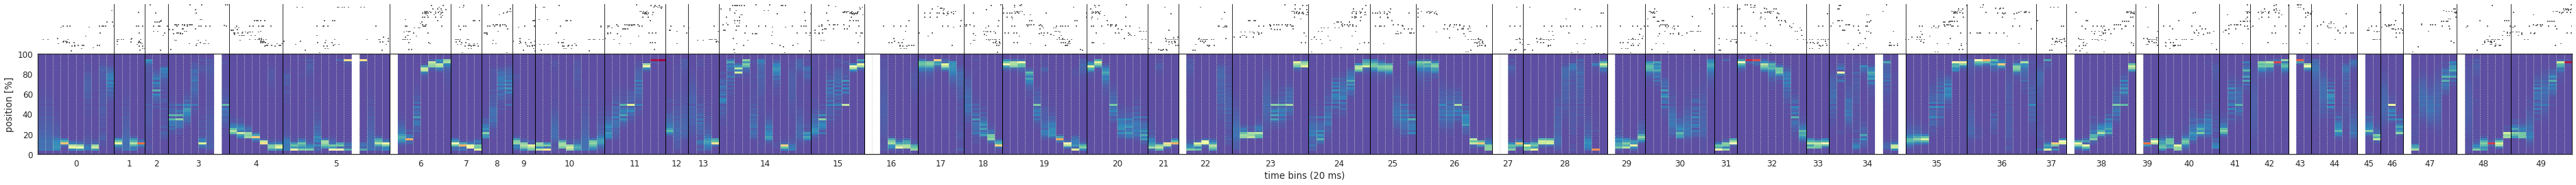

In [94]:
plot_all_PBEs(bst_placecells, sta_placecells, tc_placecells, tc_placecells, idx=range(50))


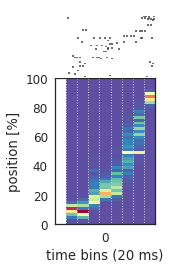

In [95]:
plot_all_PBEs(bst_placecells[38], sta_placecells, tc_placecells, tc_placecells)


In [ ]:
import time
 
t0 = time.time()
scores =  nelpy.analysis.replay.score_Davidson_final_bst(bst_placecells[38], tc_placecells, n_shuffles=50, n_samples=25000,verbose=True)
t1 = time.time()
print(t1-t0)

scoring event  1 / 1


/home/ckemere/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered


In [ ]:
scores

# hidden Markov models (HMMs)

### Preliminaries

Nelpy makes use of `hmmlearn` (https://github.com/hmmlearn/hmmlearn), but modified to include a Poisson emissions model. The modified version can be found  at https://github.com/eackermann/hmmlearn . In addition to the Poisson emissions model, this modified branch also fixed up an issue in calculating the log probabilities, as well as consistency with random seeds. The random seed issue has since been fixed in the main repository, and it is possible that the log probability issue has also been fixed, and if not, I (Etienne) should make a pull request to incorporate the fixes into the main branch. At any rate, for now, nelpy makes use of the fork at https://github.com/eackermann/hmmlearn . 

Installing `hmmlearn` should be trivial on Linux, fairly easy on MacOS, and doable on Windows. To get it to compile on Windows, all you really need is to download and install the free version of Microsoft Visual Studio (with the Python extensions), and then `hmmlearn` should compile with no issues. After installation, you can remove Visual Studio again. However, if you don't want to go through the trouble of compiling it yourself, there is also a 64-bit Windows binary in the nelpy repository.

### Overview

Here we give a quick demo of how we may use nelpy to learn hidden Markov models. Typically, HMMs are used in the absence of any [observable] behavioral correlate, but here we demonstrate the approach on the run data, where we do actually have access to the position data. Nevertheless, we don't _use_ the position data when training the HMM, nor do we need it to decode neural activity to the state space. But it does make it nice for a demo, since we can use the position data to _interpret_ what those hidden states might represent.

Briefly, we will use a `SpikeTrainArray` during bouts of running activity to learn our HMM. The HMM makes use of vectors of spike counts, so we need to bin our `SpikeTrainArray` into an appropriate bin size. Since we are learning a model on run data, we want to choose a bin size that's small enough to capture the animal's behavioral dynamics, but large enough to capture sufficiently many spikes (lot of empty bins will do us no good). Here, we will use 250 ms bins.

We will also apply a little bit of spike smoothing (300 ms standard devitation Gaussian kernel), since this has been shown to improve decoding accuracy (in general, not just for HMMs; the idea is roughly that there is some inherent noise in the signals, and so modeling that uncertainty with spike smoothing actually improves our model robustness).

Thereafter, we train our HMM on a subset of the `BinnedSpikeTrainArray` (the train set), and we can evaluate our model on the test set. We demonstrate how to decode to the state space, and also how to decode back to an actual behavioral correlate (in this cas position, if we augment our HMM with an additional mapping that we've learned between the state space and the external behavioral correlates.

There are much more that we can do with HMMs, and this section is by no means meant to be comprehensive, nor definitive, but hopefully it demonstrates how to get started, and how to do basic inference.

In [68]:
import nelpy.hmmutils

In [69]:
ds_run = 0.25 # 100 ms
ds_50ms = 0.05

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1588: UserWarning: epoch duration is less than bin size: ignoring...


In [70]:
from sklearn.model_selection import train_test_split

In [71]:
trainidx, testidx = train_test_split(np.arange(bst_run.n_epochs), test_size=0.2, random_state=1)

trainidx.sort()
testidx.sort()

bst_train = bst_run[trainidx]
bst_test = bst_run[testidx]

print('{} train sequences and {} test sequences'.format(len(trainidx),len(testidx)))

67 train sequences and 17 test sequences


/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [72]:
num_states = 30
hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
hmm.fit(bst_train)

/mnt/d/Development/Python/hmmlearn-linux/hmmlearn/utils.py:87: RuntimeWarning: divide by zero encountered in log
/mnt/d/Development/Python/hmmlearn-linux/hmmlearn/utils.py:87: RuntimeWarning: invalid value encountered in log
/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:344: UserWarning: unit tags have not yet been specified


nelpy.PoissonHMM(init_params='stm', n_components=30, n_iter=50, params='stm',
      random_state=0, verbose=False); fit=True, fit_ext=False

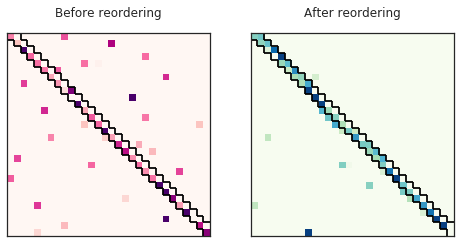

In [73]:
with npl.FigureManager(show=True, nrows=1, ncols=2, figsize=(8, 8)) as (fig, axes):
    npl.utils.skip_if_no_output(fig)
    ax0, ax1 = axes
    
    ax0.matshow(hmm.transmat_, cmap=plt.cm.RdPu)
    ax0.set_title('Before reordering')
    
    transmat_order = hmm.get_state_order('transmat')
    hmm.reorder_states(transmat_order)
    ax1.matshow(hmm.transmat_, cmap=plt.cm.GnBu)
    ax1.set_title('After reordering')
    
    for ax in axes:
        npl.utils.no_xticks(ax)
        npl.utils.no_xticklabels(ax)
        npl.utils.no_yticks(ax)
        npl.utils.no_yticklabels(ax)
    
    ys = np.arange(-0.5, num_states+0.5, step=1)
    xs = np.arange(-0.5, num_states+0.5, step=1)
    
    ax0.hlines(ys[1:-2],xs[2:-1],xs[3:])
    ax0.hlines(ys[1:-1],xs[:-1],xs[1:])
    ax0.vlines(xs[:-1],ys[:],ys[1:])
    ax0.vlines(xs[2:-1],ys[:],ys[1:])
    
    ax1.hlines(ys[1:-2],xs[2:-1],xs[3:])
    ax1.hlines(ys[1:-1],xs[:-1],xs[1:])
    ax1.vlines(xs[:-1],ys[:],ys[1:])
    ax1.vlines(xs[2:-1],ys[:],ys[1:])

Text(0,0.5,'State')

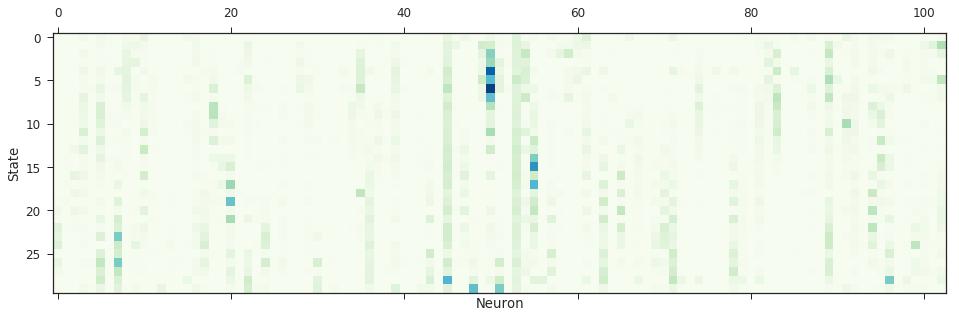

In [89]:
plt.matshow(hmm.means_, cmap=plt.cm.GnBu)
ax = plt.gca()
ax.set_xlabel('Neuron')
ax.set_ylabel('State')

### Estimate virtual tuning curves

In [74]:
ds_run = 0.125 # 100 ms
ds_50ms = 0.05
st_run = st[run_epochs]

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

/mnt/d/Development/Python/nelpy/nelpy/core/_spiketrain.py:1588: UserWarning: epoch duration is less than bin size: ignoring...


In [75]:
sigma_tc = 2

bst = bst_run
xpos = pos1d.asarray(at=bst.centers).yvals

x0=pos1d.min(); xl=pos1d.max(); n_extern=50
xx_left = np.linspace(x0,xl,n_extern+1)
xx_mid = np.linspace(x0,xl,n_extern+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=n_extern] = np.nan

extern = hmm.fit_ext(X=bst_run, ext=ext_x, n_extern=n_extern)

vtc = nel.TuningCurve1D(ratemap=extern, min_duration=0, extmin=x0, extmax=xl)
vtc = vtc.smooth(sigma=sigma_tc)

states_in_track_order = np.array(vtc.get_peak_firing_order_ids())-1

vtc.reorder_units(inplace=True)

hmm.reorder_states(states_in_track_order)

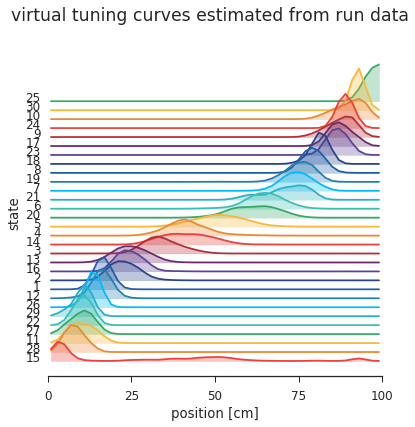

In [76]:
npl.setup(font_scale=1.2)
with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, figsize=(6, 6)) as (fig, ax):
        npl.utils.skip_if_no_output(fig)

        ax = npl.plot_tuning_curves1D(vtc, pad=0.08)
        ax.set_xlabel('position [cm]')
        ax.set_ylabel('state')
        npl.utils.xticks_interval(25)
        
        fig.suptitle('virtual tuning curves estimated from run data')


### Decoding to the state space:

In [77]:
_, posterior_states = hmm.score_samples(bst_test)

In [78]:
bst_test.lengths

array([ 6,  2,  1, 13, 11,  2,  1,  2, 18, 13, 12, 12,  1,  1,  1, 18, 12])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f29b86b3ac8>,
 <matplotlib.image.AxesImage at 0x7f29b86735f8>)

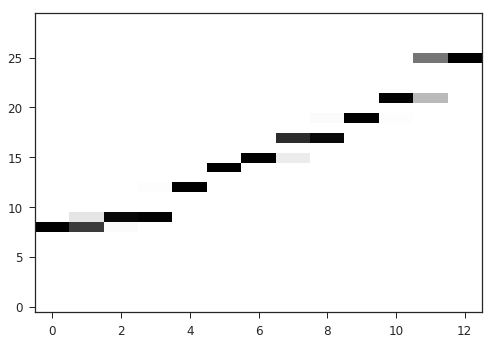

In [81]:
npl.imagesc(posterior_states[3])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f29b85ae828>,
 <matplotlib.image.AxesImage at 0x7f29b855de80>)

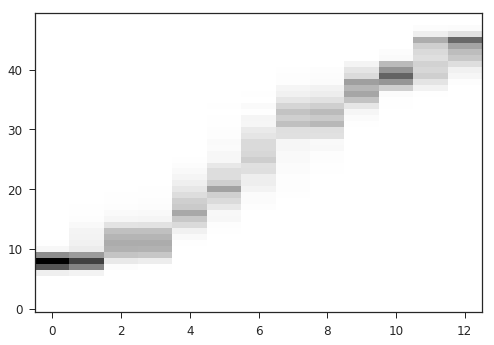

In [84]:
posteriors, bdries, mode_pth, mean_pth = hmm.decode_ext(X=bst_test[3], ext_shape=(n_extern,))

npl.imagesc(posteriors)

In [85]:
posterior_pos, bdries, mode_pth, mean_pth = hmm.decode_ext(X=bst_test, ext_shape=(vtc.n_bins,))
mean_pth = vtc.bins[0] + mean_pth*(vtc.bins[-1] - vtc.bins[0])

Text(0,0.5,'position (cm)')

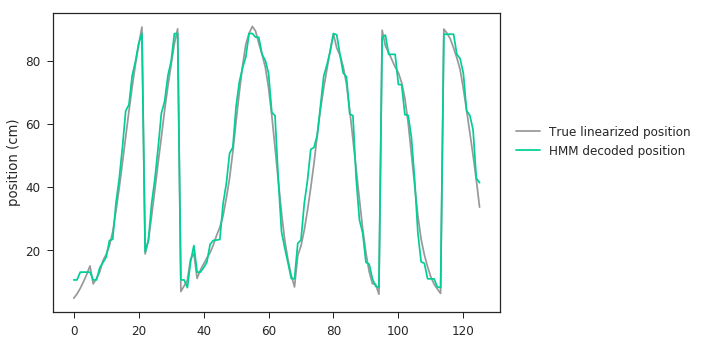

In [86]:
plt.plot(pos1d.asarray(at=bst_test.bin_centers).yvals, c='0.6', label='True linearized position')
plt.plot(mean_pth, label='HMM decoded position')
plt.legend(loc=(1.025,0.5))
plt.ylabel('position (cm)')